# Colorization of Manga and Anime Using CGAN


### Import Modules

In [1]:
import os       
import cv2
import numpy as np
import keras
from keras.layers import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.regularizers import *
from keras.utils import plot_model
from keras.callbacks import TensorBoard
from time import time
from keras.preprocessing.image import ImageDataGenerator


##This is to prevent out of memory error on cuda 10
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)
tf.keras.backend.set_session(sess)

Using TensorFlow backend.


### Genrator Model (U-Net)
- Has some basis from the Pix2Pix U-Net Generator
- Encoder layers have Batch Normalization and Leaky Relu activation
- Decoder layers have Batch Normalization and Relu activation
- Uses strides and not maxpooling
- Final activation function is Tanh with two channels (for Blue and Green. Red layer can be deduced using the grayscale input and the other color channels)

In [2]:
def generator_model_g2c(x_shape,y_shape):
    
    # encoder
    generator_input = Input(batch_shape=(None,x_shape,y_shape, 1), name='generator_input')
    
    conv1_32 = Conv2D(16,kernel_size=(3,3),strides=(1,1),padding='same', kernel_regularizer=l2(0.001))(generator_input)
    conv1_32 = LeakyReLU(alpha=0.1)(conv1_32)
    conv1_32 = BatchNormalization()(conv1_32)
    
    conv2_64 = Conv2D(32,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001))(conv1_32)
    conv2_64 = LeakyReLU(alpha=0.1)(conv2_64)
    conv2_64 = Conv2D(32,kernel_size=(3,3),padding='same',strides = 2,kernel_regularizer=l2(0.001))(conv2_64)
    conv2_64 = LeakyReLU(alpha=0.1)(conv2_64)    
    conv2_64 = BatchNormalization()(conv2_64)
    
    conv3_128 = Conv2D(64,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001))(conv2_64)
    conv3_128 = LeakyReLU(alpha=0.1)(conv3_128)
    conv3_128 = Conv2D(64,kernel_size=(3,3),padding='same',strides = 2,kernel_regularizer=l2(0.001))(conv3_128)
    conv3_128 = LeakyReLU(alpha=0.1)(conv3_128)
    conv3_128 = BatchNormalization()(conv3_128)
    
    conv4_256 = Conv2D(128,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001))(conv3_128)
    conv4_256 = LeakyReLU(alpha=0.1)(conv4_256)
    conv4_256 = Conv2D(128,kernel_size=(3,3),padding='same',strides = 2,kernel_regularizer=l2(0.001))(conv4_256)
    conv4_256 = LeakyReLU(alpha=0.1)(conv4_256)
    conv4_256 = BatchNormalization()(conv4_256)
    
    conv5_512 = Conv2D(256,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001))(conv4_256)
    conv5_512 = LeakyReLU(alpha=0.1)(conv5_512)
    conv5_512 = Conv2D(256,kernel_size=(3,3),padding='same',strides = 2,kernel_regularizer=l2(0.001))(conv5_512)
    conv5_512 = LeakyReLU(alpha=0.1)(conv5_512)
    conv5_512 = BatchNormalization()(conv5_512)
    
    conv6_512 = Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001))(conv5_512)
    conv6_512 = LeakyReLU(alpha=0.1)(conv6_512)
    conv6_512 = Conv2D(512,kernel_size=(3,3),padding='same',strides = 2,kernel_regularizer=l2(0.001))(conv5_512)
    conv6_512 = LeakyReLU(alpha=0.1)(conv6_512)
    conv6_512 = BatchNormalization()(conv6_512)
    
    conv7_512 = Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001))(conv6_512)
    conv7_512 = LeakyReLU(alpha=0.1)(conv7_512)
    conv7_512 = BatchNormalization()(conv7_512)
    
    # decoder
    conv8_512 = Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001))(conv7_512)
    conv8_512 = LeakyReLU(alpha=0.1)(conv8_512)
    conv8_512 = BatchNormalization(axis=1)(conv8_512)
    
    deconv9_512 = Conv2DTranspose(512,kernel_size=(3,3),padding='same',activation='relu',strides=(2,2),kernel_regularizer=l2(0.001))(conv8_512)
    deconv9_512 = BatchNormalization()(deconv9_512)
    deconv9_512 = Concatenate()([deconv9_512,conv5_512])
    deconv9_512 = Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(0.001))(deconv9_512)
    deconv9_512 = BatchNormalization()(deconv9_512)
    
    deconv10_256 = Conv2DTranspose(256,kernel_size=(3,3),padding='same',activation='relu',strides=(2,2),kernel_regularizer=l2(0.001))(deconv9_512)
    deconv10_256 = BatchNormalization()(deconv10_256)
    deconv10_256 = Concatenate()([deconv10_256,conv4_256])
    deconv10_256 = Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(0.001))(deconv10_256)
    deconv10_256 = BatchNormalization()(deconv10_256)
    
    deconv11_128 = Conv2DTranspose(128,kernel_size=(3,3),padding='same',activation='relu',strides=(2,2),kernel_regularizer=l2(0.001))(deconv10_256)
    deconv11_128 = Concatenate()([deconv11_128,conv3_128])
    deconv11_128 = Conv2D(128,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(0.001))(deconv11_128)
    
    deconv12_64 = Conv2DTranspose(64,kernel_size=(3,3),padding='same',activation='relu',strides=(2,2),kernel_regularizer=l2(0.001))(deconv11_128)
    deconv12_64 = Concatenate()([deconv12_64,conv2_64])
    deconv12_64 = Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(0.001))(deconv12_64)
    
    deconv13_32 = Conv2DTranspose(32,kernel_size=(3,3),padding='same',activation='relu',strides=(2,2),kernel_regularizer=l2(0.001))(deconv12_64)
    deconv13_32 = Concatenate()([deconv13_32,conv1_32])
    deconv13_32 = Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(0.001))(deconv13_32)
    
    deconv14_16 = Conv2DTranspose(16,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(0.001))(deconv13_32)
    deconv14_16 = Conv2D(16,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(0.001))(deconv14_16)
    
    output = Conv2D(2,kernel_size=(1,1),padding='same',activation='tanh')(deconv14_16)
    
    model = Model(inputs=generator_input,outputs=output)
    
    return model

W0524 19:45:43.683614 140096226400064 deprecation.py:506] From /home/chico/.virtualenvs/dl4cv/lib/python3.6/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Text(0.5, 1.0, 'Gray-2-Color Generator Model')

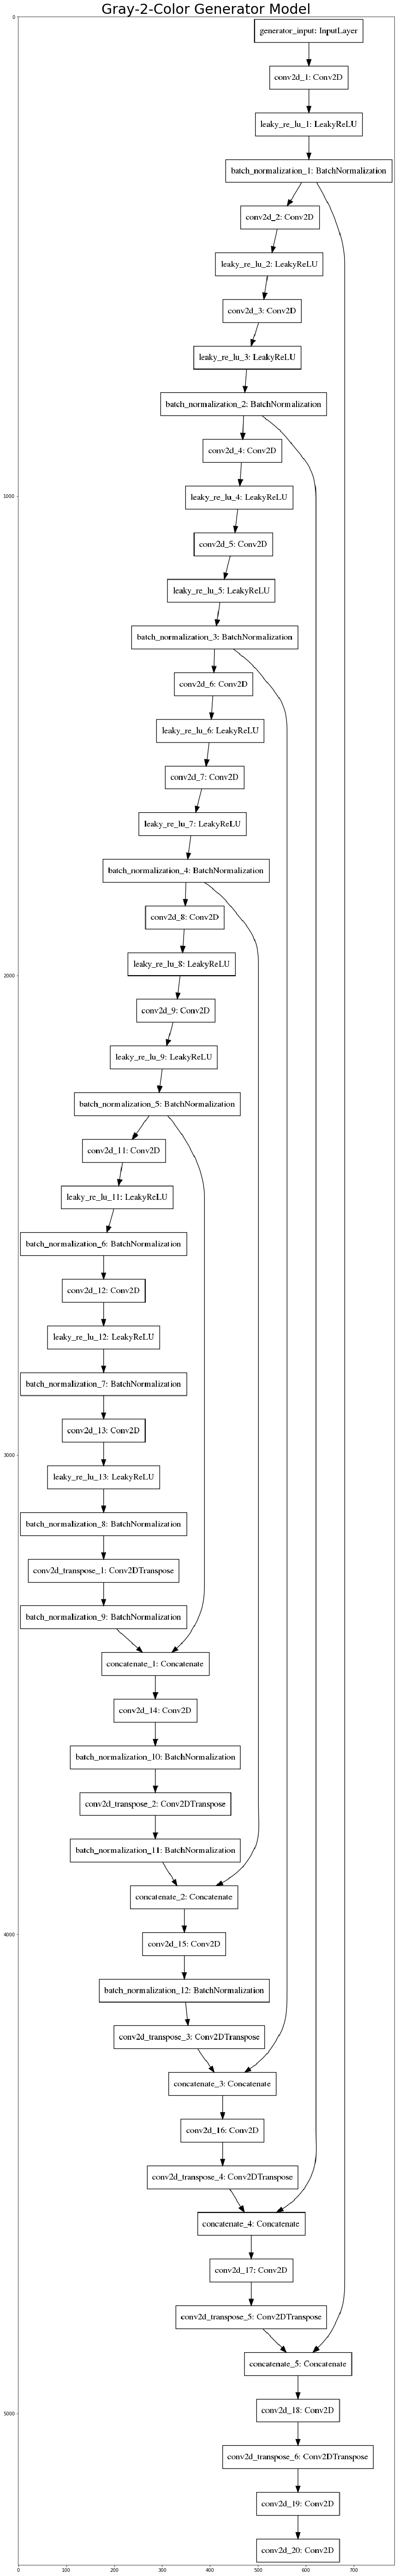

In [3]:
%matplotlib inline
x_shape = 512
y_shape = 512

gen_g2c = generator_model_g2c(x_shape,y_shape)
plot_model(gen_g2c, to_file='gen_g2c.png')
img = cv2.imread('gen_g2c.png',)
plt.figure(figsize=(15,15*img.shape[0]/img.shape[1]))
plt.subplot(111),plt.imshow(img,cmap = 'gray')
plt.title('Gray-2-Color Generator Model',fontsize=30)

### CGAN Discriminator
- Takes in two inputs: the generator output (colorized image) and the generator input (grayscale image)
- the generator input acts as the label.
- uses elu activation and batch normalization
- After some convolving, the two inputs merge
- final activation function is sigmoid

In [4]:
def discriminator_model_g2c(x_shape,y_shape):
    
    generator_input = Input(batch_shape=(None, x_shape, y_shape, 1), name='generator_input')
    generator_output = Input(batch_shape=(None, x_shape, y_shape, 2), name='generator_output')
    
    input1 = BatchNormalization()(generator_input)
    input2 = BatchNormalization()(generator_output)
    
    convi = Conv2D(32,kernel_size=(3,3),activation='elu',padding='same',kernel_regularizer=l2(0.001))(generator_input)
    convi = BatchNormalization()(convi)
    
    convo = Conv2D(32,kernel_size=(3,3),activation='elu',padding='same',kernel_regularizer=l2(0.001))(generator_output)
    convo = BatchNormalization()(convo)

    
    convi = Conv2D(64,kernel_size=(3,3),activation='elu',padding='same',kernel_regularizer=l2(0.001))(convi)
    convi = BatchNormalization()(convi)
    
    convo = Conv2D(64,kernel_size=(3,3),activation='elu',padding='same',kernel_regularizer=l2(0.001))(convo)
    convo = BatchNormalization()(convo)

    
    convi = Conv2D(64,kernel_size=(3,3),strides=(2,2),activation='elu',padding='same',kernel_regularizer=l2(0.001))(convi)
    convo = Conv2D(64,kernel_size=(3,3),strides=(2,2),activation='elu',padding='same',kernel_regularizer=l2(0.001))(convo)
    
    conv = Concatenate()([convi,convo])
    conv = BatchNormalization()(conv)
    
    conv = Conv2D(128,kernel_size=(3,3),strides=(2,2),activation='elu',padding='same',kernel_regularizer=l2(0.001))(conv)
    conv = BatchNormalization()(conv)
    
    conv = Conv2D(128,kernel_size=(3,3),strides=(2,2),activation='elu',padding='same',kernel_regularizer=l2(0.001))(conv)
    conv = BatchNormalization()(conv)
    
    conv = Conv2D(128,kernel_size=(3,3),strides=(2,2),activation='elu',padding='same',kernel_regularizer=l2(0.001))(conv)
    conv = BatchNormalization()(conv)
    
    conv = Conv2D(256,kernel_size=(3,3),strides=(2,2),activation='elu',padding='same',kernel_regularizer=l2(0.001))(conv)
    conv = BatchNormalization()(conv)
    
    conv = Conv2D(256,kernel_size=(3,3),strides=(2,2),activation='elu',padding='same')(conv)
    conv = BatchNormalization()(conv)
    
    conv = Flatten()(conv)
    conv = Dropout(0.5)(conv)
    
    conv = Dense(100,activation='elu')(conv)
    conv = Dropout(0.5)(conv)
    
    output = Dense(1,activation='sigmoid')(conv)
    
    model = Model(inputs=([generator_input,generator_output]),outputs=[output])
    
    return model

W0524 19:45:49.651014 140096226400064 deprecation.py:506] From /home/chico/.virtualenvs/dl4cv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Text(0.5, 1.0, 'Gray-2-Color Discriminator Model')

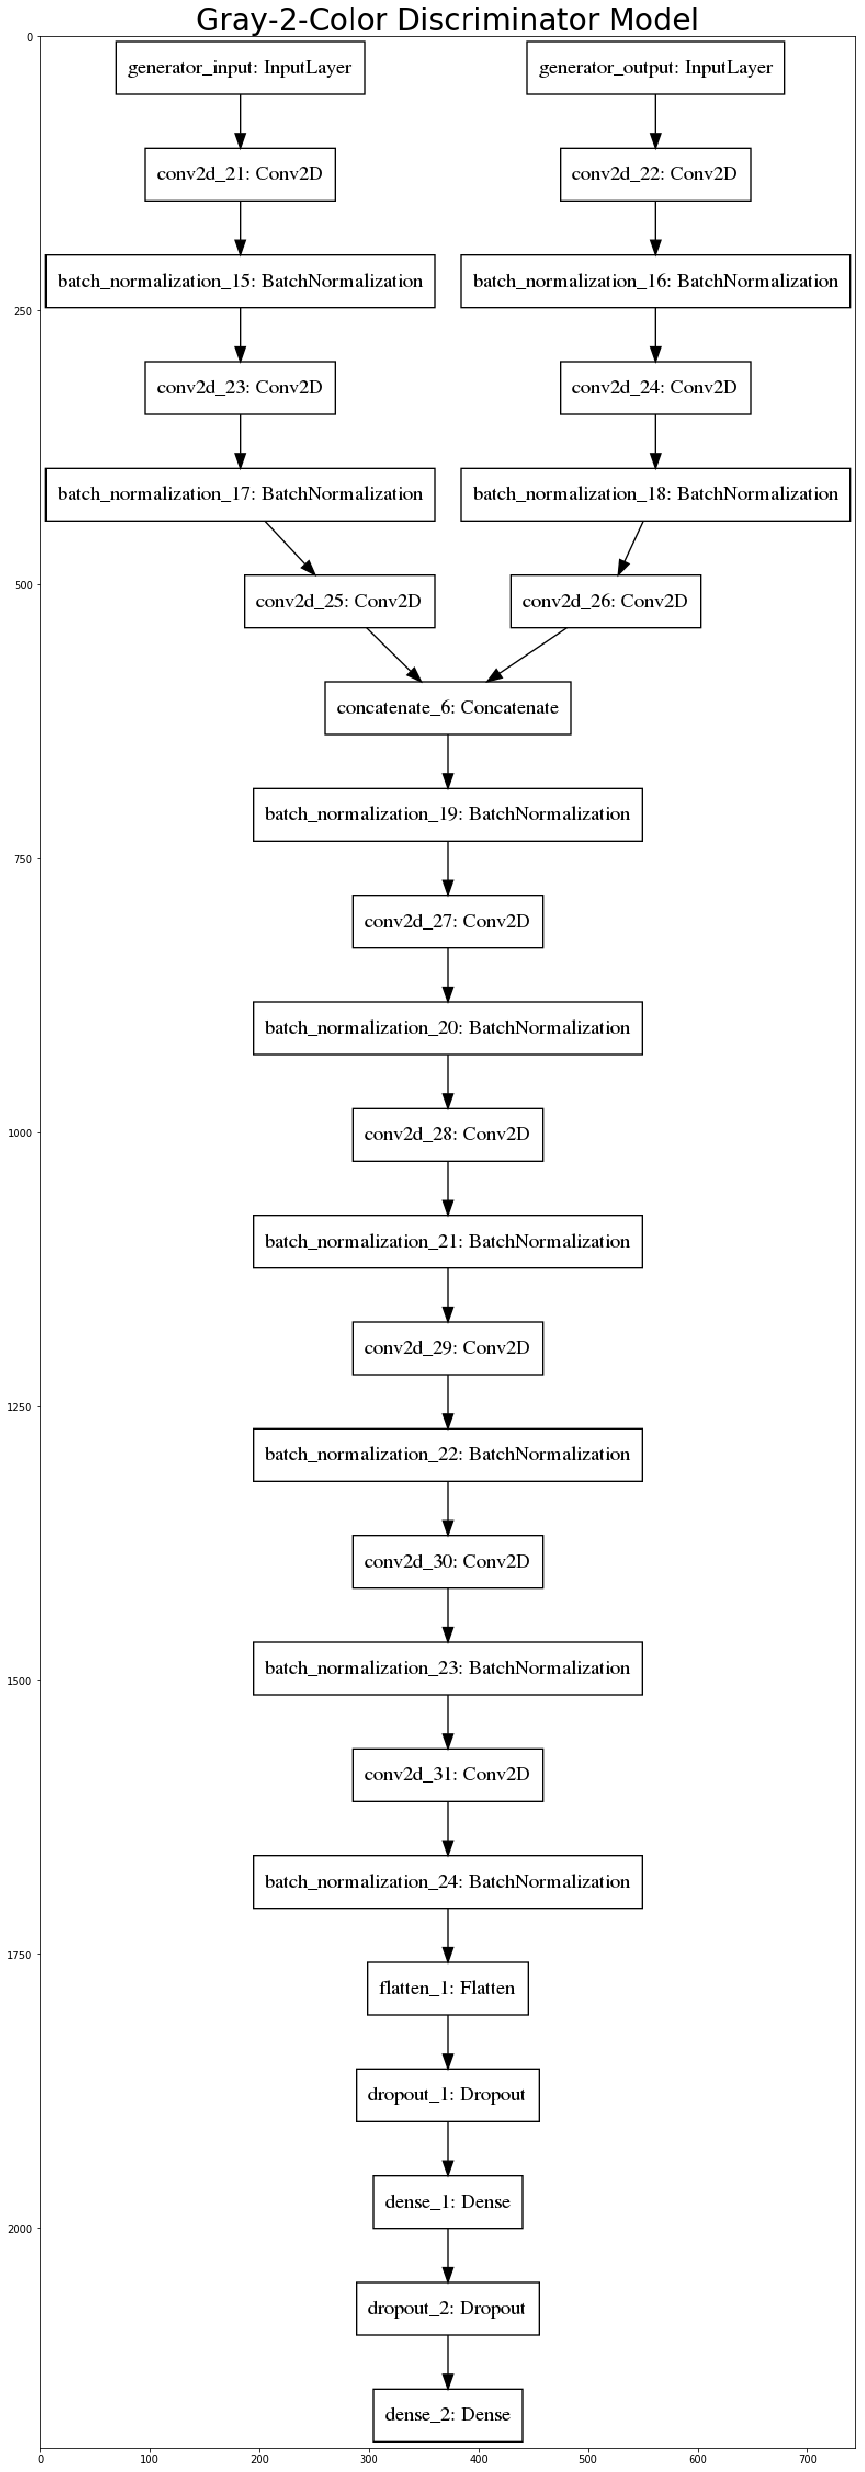

In [5]:
disc_g2c = discriminator_model_g2c(x_shape,y_shape)

plot_model(disc_g2c, to_file='disc_g2c.png')
img = cv2.imread('disc_g2c.png',)
plt.figure(figsize=(15,15*img.shape[0]/img.shape[1]))
plt.subplot(111),plt.imshow(img,cmap = 'gray')
plt.title('Gray-2-Color Discriminator Model',fontsize=30)

### CGAN Adversarial Model
- the full CGAN model
- Two outputs: the Discriminator output and the Generator output

In [6]:
def advr_model_g2c(generator,discriminator):
    
    discriminator.trainable = False
    model = Model(inputs=generator.input,outputs=[discriminator([generator.input,generator.output]),generator.output])
    
    return model

In [7]:
advr_g2c = advr_model_g2c(gen_g2c,disc_g2c)

### Load trained weights

In [8]:
advr_g2c.load_weights("../data/data_out8-mangacolor/updated.h5")

### Input Grayscale Image

Text(0.5, 1.0, 'Input')

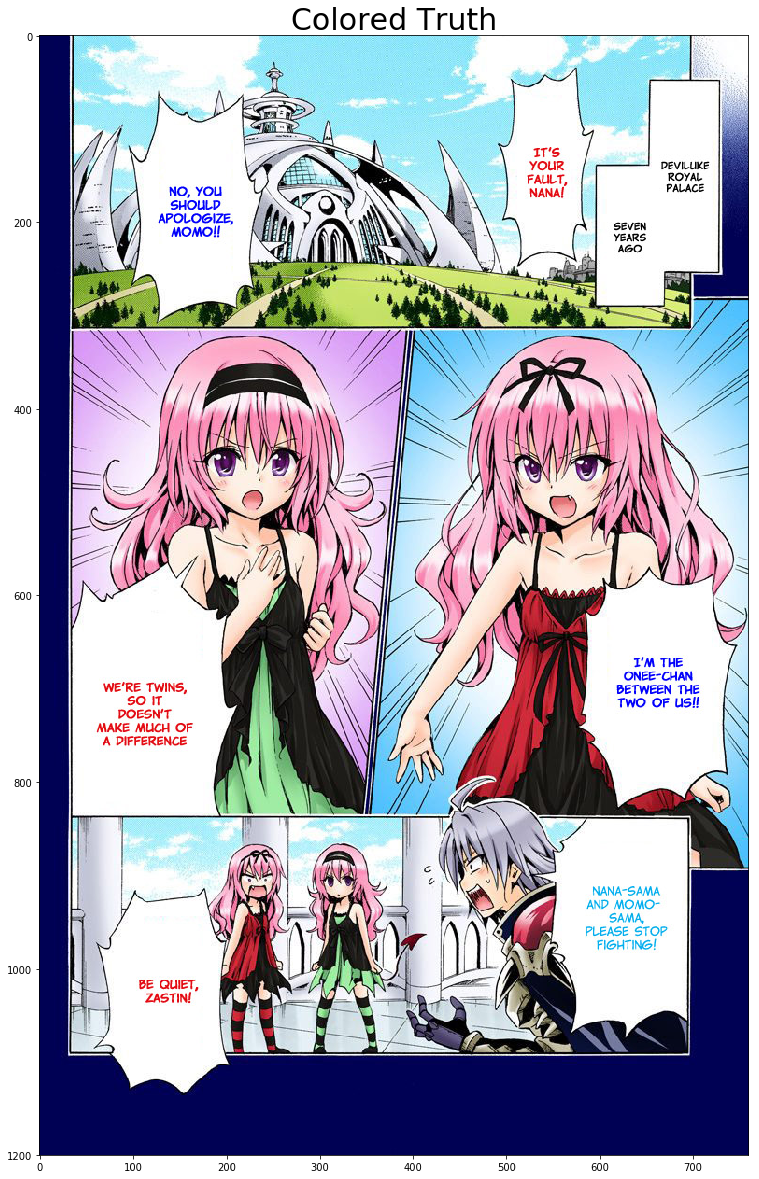

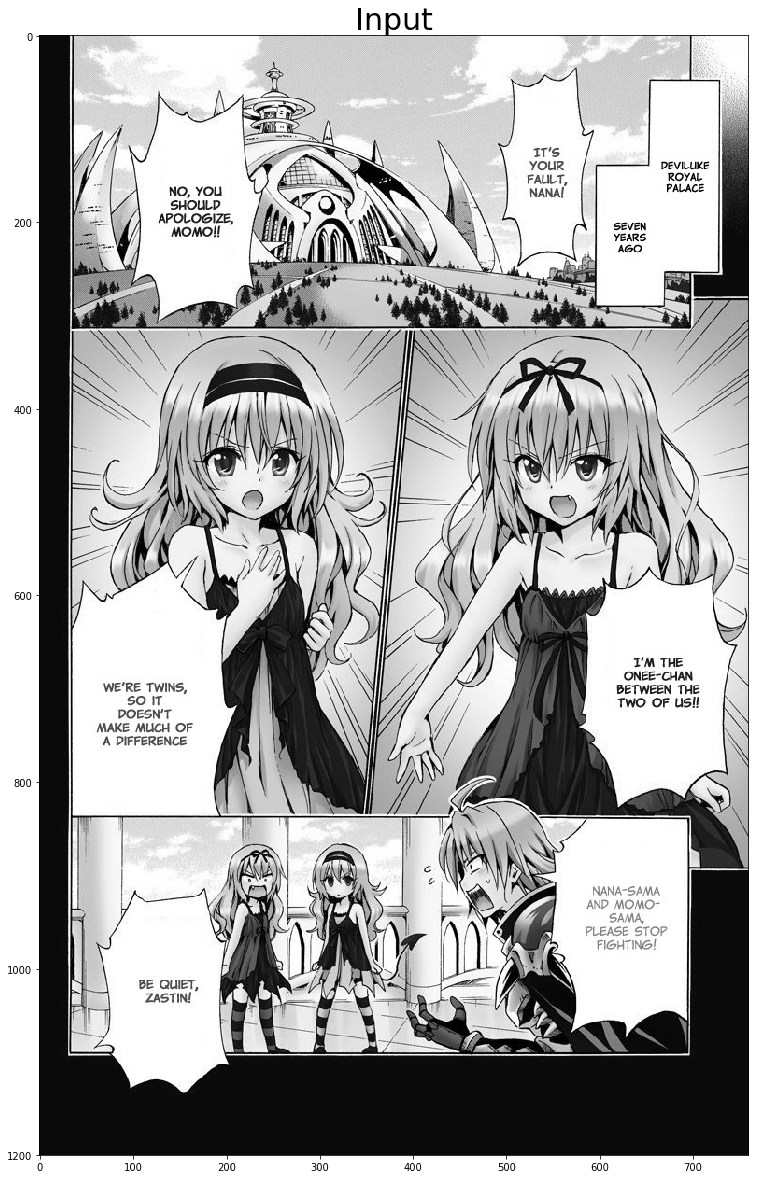

In [25]:
img = "../data/validation_set/072.jpg"

img0 = cv2.imread(img,)
gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY) * 1.0
plt.figure(figsize=(60,60*img0.shape[0]/img0.shape[1]))
plt.subplot(411),plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
plt.title('Colored Truth',fontsize=30)
plt.figure(figsize=(60,60*img0.shape[0]/img0.shape[1]))
plt.subplot(412),plt.imshow(gray,cmap = 'gray')
plt.title('Input',fontsize=30)

Text(0.5, 1.0, 'Output')

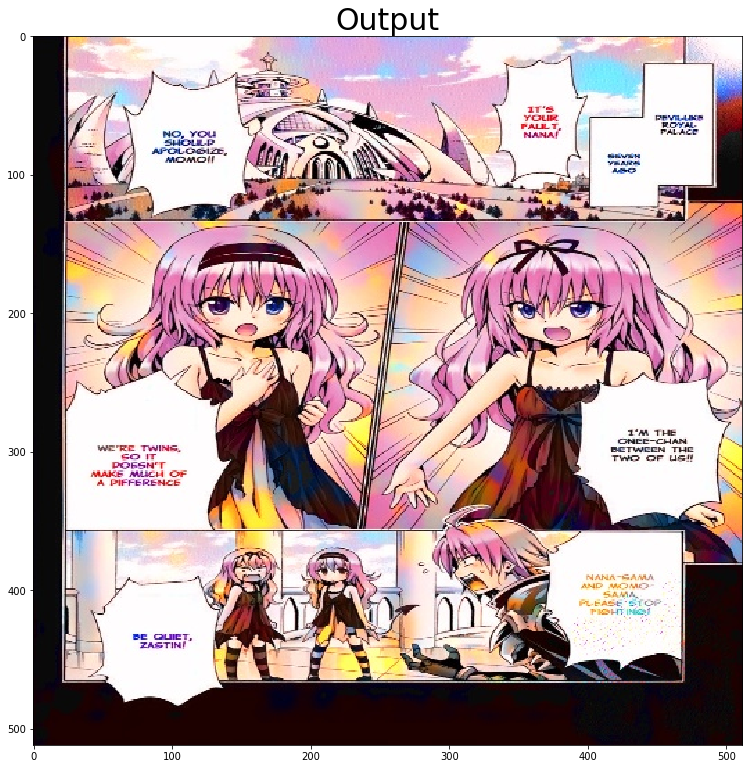

In [23]:
gray = cv2.resize(gray, (x_shape, y_shape))
gray = gray.reshape(gray.shape[0], gray.shape[1], 1)
val_gray = []
val_gray.append(gray)
val_gray = np.array(val_gray)
val_gray = (val_gray-127.5)/127.5

gen_image_val_2 = (gen_g2c.predict(val_gray, batch_size=8)*127.5)+127.5
gen_image_val = np.zeros((len(gen_image_val_2), gen_image_val_2.shape[1], gen_image_val_2.shape[2], 3))
gen_image_val[:,:,:,:-1] = gen_image_val_2
gen_image_val[:,:,:,2] = ((val_gray[:,:,:,0]*127.5)+127.5)*3  - gen_image_val[:,:,:,0] - gen_image_val[:,:,:,1]



np.clip(gen_image_val,0,255, out = gen_image_val)
gen_image_val = gen_image_val//1
gen_image_val = gen_image_val.astype(np.uint8)
for i in range(gen_image_val.shape[0]):
    gen_image_val[i] = cv2.cvtColor(gen_image_val[i], cv2.COLOR_BGR2HSV)
gen_image_val[:,:,:,1] =  (255-((255-gen_image_val[:,:,:,1])/255)**1.5)*255
for i in range(gen_image_val.shape[0]):
    gen_image_val[i] = cv2.cvtColor(gen_image_val[i], cv2.COLOR_HSV2BGR)
gen_image_val = gen_image_val*1.0
for i in range(gen_image_val.shape[0]):
    gg = ((val_gray[i,:,:,0]*127.5)+127.5)*3/(gen_image_val[i,:,:,0] + gen_image_val[i,:,:,1] + gen_image_val[i,:,:,2] + 0.01)
    for j in range(3):
        gen_image_val[i,:,:,j] = gen_image_val[i,:,:,j]*gg


gen_image_val = gen_image_val//1
cv2.imwrite('out.jpg', gen_image_val[0])

color = cv2.imread('out.jpg',)
color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(60,60*gen_image_val[0].shape[0]/gen_image_val[0].shape[1]))
plt.subplot(411),plt.imshow(color)
plt.title('Output',fontsize=30)